In [1]:
import os
from dotenv import load_dotenv

load_dotenv(override=True)
OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    api_key=OPENAI_API_KEY
)

In [3]:
from typing import TypedDict, List

class CollaborationState(TypedDict):
    task: str
    plan: List[str]
    draft: str
    reviewed_output: str

In [4]:
def planner_node(state: CollaborationState) -> CollaborationState:
    prompt = f"""
You are a planning agent.

Break the following task into clear, ordered steps.

Task:
{state['task']}

Return only a numbered list.
"""

    response = llm.invoke(prompt)
    steps = [
        line.strip()
        for line in response.content.split("\n")
        if line.strip() and line.strip()[0].isdigit()
    ]

    return {
        **state,
        "plan": steps
    }


In [5]:
def executor_node(state: CollaborationState) -> CollaborationState:
    plan_text = "\n".join(state["plan"])

    prompt = f"""
You are an execution agent.

Follow the plan below to complete the task.

Plan:
{plan_text}

Task:
{state['task']}
"""

    response = llm.invoke(prompt)

    return {
        **state,
        "draft": response.content
    }

In [6]:
def reviewer_node(state: CollaborationState) -> CollaborationState:
    prompt = f"""
You are a review agent.

Task:
{state['task']}

Draft output:
{state['draft']}

Review the draft and improve clarity, correctness, and completeness.
"""

    response = llm.invoke(prompt)

    return {
        **state,
        "reviewed_output": response.content
    }


In [7]:
from langgraph.graph import StateGraph, END

graph = StateGraph(CollaborationState)

graph.add_node("planner", planner_node)
graph.add_node("executor", executor_node)
graph.add_node("reviewer", reviewer_node)

graph.set_entry_point("planner")

graph.add_edge("planner", "executor")
graph.add_edge("executor", "reviewer")
graph.add_edge("reviewer", END)

app = graph.compile()

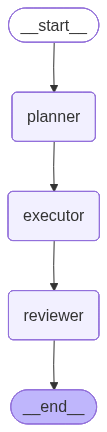

In [8]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [9]:
task = "help me acheive financial indepedence"

initial_state: CollaborationState = {
    "task": task,
    "plan": [],
    "draft": "",
    "reviewed_output": ""
}

final_state = app.invoke(initial_state)


In [10]:
print("Plan:")
for step in final_state["plan"]:
    print("-", step)

print("\nFinal Output:")
print(final_state["reviewed_output"])

Plan:
- 1. Assess Current Financial Situation
- 2. Set Clear Financial Goals
- 3. Create a Budget
- 4. Reduce Expenses
- 5. Increase Income
- 6. Build an Emergency Fund
- 7. Pay Off Debt
- 8. Invest for the Future
- 9. Monitor and Adjust Financial Plan
- 10. Educate Yourself on Personal Finance
- 11. Seek Professional Advice
- 12. Stay Committed and Patient

Final Output:
Achieving financial independence is a commendable goal, and following a structured plan is a great way to get started. Let’s break down each step to help you on your journey:

### 1. Assess Your Current Financial Situation
- **Gather Financial Statements**: Collect your bank statements, investment accounts, and any other relevant financial documents.
- **Calculate Your Net Worth**: List all assets (what you own) and liabilities (what you owe) to determine your net worth.
- **Analyze Income and Expenses**: Track your monthly income and expenses to understand your cash flow and identify spending patterns.

### 2. Set Cl